## Midterm solution

## Part 1 - Scraping - 5 points

1. go to [WIKI](https://en.wikipedia.org/wiki/FTSE_100_Index)
2. scrape the table and iterate over constituents:
    - for each company save their ticker and the industry they operate in
    - you will use this in the Data analysis part 3 for some basic processing.
)

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
r = requests.get('https://en.wikipedia.org/wiki/FTSE_100_Index')
soup = BeautifulSoup(r.text,'lxml')

In [3]:
table=soup.find('table',{'id':'constituents'}).find('tbody').findAll('tr')[1:]

In [4]:
df_scraped = pd.DataFrame()
for row in table:
        title = row.find('a')['title']
        ticker = row.findAll('td')[1].text
        industry = row.findAll('td')[2].text.strip()
        row_ = pd.Series({"Ticker":ticker,"Industry":industry},name=title)
        df_scraped = pd.concat([df_scraped, row_], axis=1)
df_scraped = df_scraped.T

In [5]:
df_scraped

,Ticker,Industry
3i,III,Financial Services
Admiral Group,ADM,Nonlife Insurance
Anglo American plc,AAL,Mining
Antofagasta PLC,ANTO,Mining
Ashtead Group,AHT,Support Services
...,...,...
Unilever,ULVR,Personal Goods
United Utilities,UU.,"Gas, Water & Multi-utilities"
Vodafone,VOD,Mobile Telecommunications
Whitbread,WTB,Retail hospitality


## Part 2

* In this part, you are expected to obtain a dataset from an API. There might be some obstacles. You need to complete the dataset and use it in part 3. If you do not manage it, you can obtain the dataset anyway, but you forfeit the points for this part. You might obtain some partial points if you do not complete the section.


* API address: https://ies-midterm.soulution.rocks/
    * if you receive an error, read the message! you might obtain an informative message
    * if you see `{"message":"Missing Authentication Token"}`, then you are using a wrong request method on the endpoint. i.e. /login needs a POST, if you send a GET, you will see this. 
    
**Tips:**
* you might want to check the status code of the response for your request. Code 200 is good, everything else suggests a problem. Then you might want to print the text of the response, where you find out what is wrong
* when you are sending a payload (if not sure, google how to send data with a request), make sure it is a properly formatted JSON string (you can check wiki what a JSON properly looks like - or a linter https://jsonlint.com/)
* when receiving partial data; you might want to save them in a container after a successful call (you know each has 5 codes). Then you need to figure out how to merge those together in one object.




| endpoint          | method allowed | payload required                                |
|-------------------|----------------|-------------------------------------------------|
| /login            | POST           | {“cuni”:”your_number”} as JSON-formatted string |
| /data/{data_code} | GET            | -                                               |
| /saveme           | POST           | {“cuni”:”your_number”} as JSON-formatted string |

1. log in the API by sending a POST to /login endpoint
    - use payload of JSON type string ‘{"cuni":"yourCUNInumber"}’ to authenticate
    - print the personal_code you find in the response,
    - save the list of codes for this is your generated dataset

2. for each of the codes you received from /login, call send a GET to /data/{data_code} to receive a part of the dataset
    - replace the second part of the path with the code, like /data/a12asda
    - you will receive a JSON response with the name of the company it belongs to and data. Structure is:
        - {“data”:{“company”:”IES”, “data”:[]}}
    - note the name of the company wit
    - API can return an error h 0.33 probability. Your job is to handle it.
    


In [6]:
import json
import time

In [7]:
payload = '{"cuni":"53145055"}'
r = requests.post('https://ies-midterm.soulution.rocks/login',payload)

In [8]:
r

<Response [200]>

In [9]:
d = json.loads(r.text)

In [10]:
d['message']

'Hello, Martin bez Kytek! Good luck with the midterm. GET your data set from /data/file_id endpoint; use the codes you received in the data response as the file_id parameter! Print the personal code in your notebook.'

In [11]:
d['data']['personal_code']

'ba31997951'

In [12]:
codes = d['data']['dataset_ids'][0]

In [13]:
codes

['24f88cb68c', 'f894683be9', '403c8fd1da', '3e8641892a', '288b147f95']

In [14]:
collector = {}
n_attempts = 10
for data_id in codes:
    r = requests.get(url=f'https://ies-midterm.soulution.rocks/data/{data_id}')
    i = 0
    while r.status_code !=200:  
        r=requests.get(url=f'https://ies-midterm.soulution.rocks/data/{data_id}')
        time.sleep(1)
    d=r.json()['data']
    
    ticker = d['company']
    data = pd.DataFrame(d['data']).set_index('Date')
    data.index = pd.to_datetime(data.index)
    
    collector[ticker] = data
df = pd.concat(collector)
df.index.names = ['Ticker','Date']
df.dropna(how='all',inplace = True)
df = df.apply(lambda x: pd.to_numeric(x))

In [15]:
df

Open        High         Low       Close   Adj.Close  \
Ticker Date                                                                     
PSN    2019-05-08   30.650000   31.440001   29.200001   30.070000   30.070000   
       2019-05-09   29.639999   30.299999   29.030001   30.100000   30.100000   
       2019-05-10   29.889999   31.350000   29.500000   31.010000   31.010000   
       2019-05-13   30.290001   31.670000   29.750000   31.059999   31.059999   
       2019-05-14   31.100000   32.599998   31.020000   31.750000   31.750000   
...                       ...         ...         ...         ...         ...   
JET    2020-11-13  182.850006  182.850006  180.000000  182.500000  182.500000   
       2020-11-16  182.850006  182.899994  180.050003  180.050003  180.050003   
       2020-11-17  182.899994  187.250000  182.000000  187.100006  187.100006   
       2020-11-19  187.000000  193.500000  187.000000  191.949997  191.949997   
       2020-11-20  190.000000  193.899994  187.550003  190.000000  190.000000   

                     Volume  
Ticker Date                  
PSN    2019-05-08  14793400  
       2019-05-09   1719300  
       2019-05-10    739700  
       2019-05-13   1040700  
       2019-05-14   2409100  
...                     ...  
JET    2020-11-13      1003  
       2020-11-16       314  
       2020-11-17      5393  
       2020-11-19      6114  
       2020-11-20      7498  

[1820 rows x 6 columns]

## Part 3

In this part, you can obtain up to 5 bonus points for hard tasks.
We suggest creating a pandas DataFrame with the data. You might want to create a DF with dates on the index, and a column per company. 

Analyze scraping output:
for the whole FTSE index:
- find the most and least represented industries
- create a histogram of the frequency of industries

Analysis of your dataset - find the following quantities
**per company**:
- the time series should be from 2019-01-02 to 2020-11-20. Is it the case in your sample?
- what is the highest and lowest Adj Close price the company recorded?
- what day was the highest number of shares traded
- what is the total of shares traded
- for the company with the highest turnover of shares, plot their share price over time

**Bonus tasks**:
- when did the company record the highest gain and highest loss for the day? (logarithmic loss) - 1 point
- plot the log returns for the company that has the largest difference between opening and closing price. What day and what company did it occur at? - 1 point
- find monthly returns. Which company has the highest recorded? - 1 point
- for stocks with full time series, calculate 10day volatility by calculating the standard deviation of the previous 10 days. (i.e. 10th day is the first observation and it includes given day) - 2 points


### Scraped

In [16]:
df_scraped['Industry'].value_counts().idxmax()

'Support Services'

In [17]:
df_scraped['Industry'].value_counts().idxmin()

'Food Producers'

In [18]:
df_scraped['Industry'].value_counts()

Support Services                       8
Media                                  6
Mining                                 6
Life Insurance                         5
Household Goods & Home Construction    5
Financial Services                     5
Banks                                  5
Food & Drug Retailers                  4
Real Estate Investment Trusts          3
Pharmaceuticals & Biotechnology        3
Travel & Leisure                       3
Gas, Water & Multi-utilities           3
General Industrials                    3
Aerospace & Defence                    2
General Retailers                      2
Software and Computer Services         2
Tobacco                                2
Personal Goods                         2
Software & Computer Services           2
Retailers                              2
Chemicals                              2
Nonlife Insurance                      2
Beverages                              2
Oil & Gas Producers                    2
Food Producers  

In [19]:
df_scraped['Industry']

3i                              Financial Services
Admiral Group                    Nonlife Insurance
Anglo American plc                          Mining
Antofagasta PLC                             Mining
Ashtead Group                     Support Services
                                  ...             
Unilever                            Personal Goods
United Utilities      Gas, Water & Multi-utilities
Vodafone                 Mobile Telecommunications
Whitbread                       Retail hospitality
WPP plc                                      Media
Name: Industry, Length: 100, dtype: object

<AxesSubplot:>

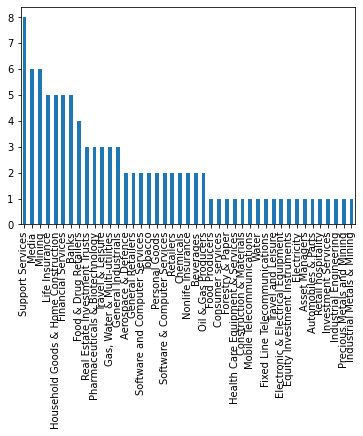

In [20]:
df_scraped['Industry'].value_counts().plot(kind='bar')

### From API

In [21]:
df.reset_index('Date')['Date'].groupby('Ticker').min()

Ticker
BHP   2019-01-02
CPG   2019-01-02
JET   2019-01-02
PSN   2019-05-08
RTO   2020-01-24
Name: Date, dtype: datetime64[ns]

In [22]:
df.reset_index('Date')['Date'].groupby('Ticker').max()

Ticker
BHP   2020-11-20
CPG   2020-11-20
JET   2020-11-20
PSN   2020-11-20
RTO   2020-01-24
Name: Date, dtype: datetime64[ns]

In [23]:
df.groupby('Ticker')['Adj.Close'].max()

Ticker
PSN      45.029999
RTO    1865.000000
CPG       4.765612
BHP      56.848785
JET     346.950012
Name: Adj.Close, dtype: float64

In [24]:
df.groupby('Ticker')['Adj.Close'].min()

Ticker
PSN      25.309999
RTO    1865.000000
CPG       0.608388
BHP      30.326542
JET     156.100006
Name: Adj.Close, dtype: float64

In [25]:
df.groupby('Ticker')['Volume'].idxmax()

Ticker
PSN    (PSN, 2019-05-08 00:00:00)
RTO    (RTO, 2020-01-24 00:00:00)
CPG    (CPG, 2020-05-18 00:00:00)
BHP    (BHP, 2020-03-11 00:00:00)
JET    (JET, 2020-01-09 00:00:00)
Name: Volume, dtype: object

In [26]:
df.groupby('Ticker')['Volume'].sum() 

Ticker
PSN     168647400
RTO             0
CPG    1225230300
BHP    1058997600
JET        767178
Name: Volume, dtype: int64

<AxesSubplot:xlabel='Date'>

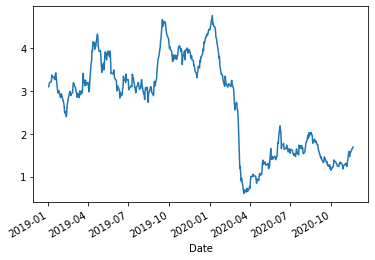

In [27]:
df.loc['CPG',:]['Adj.Close'].plot()